<a href="https://colab.research.google.com/github/CS7140/PA-3/blob/master/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rajesh Sakhamuru
# **Perceptron for Linearly Separable Data**


In [1]:
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

In [2]:
# data visualization options for console output
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)

In [3]:
def perceptron(originalData, target, learningRate):
    '''
    Calculates the weights to assign to features using the perceptron algorithm.
    
    :param originalData: pandas dataframe data
    :param target: target column name
    :param learningRate: learning rate to limit gradient descent jumps
    '''

    data = originalData.copy()

    colNames = getColNames(data)

    featList = colNames.copy()
    if target in colNames:
        featList.remove(target)

    weights = [[0]] * len(featList)

    weightsMatrix = np.array(weights)

    targetCol = data[target].values.tolist()
    targetMatrix = np.array([[n] for n in targetCol])

    dataMatrix = np.array(data.drop(columns=[target]))

    converged = False

    count = 0
    while not converged:
        # calculate predicted values using current weights
        predictedMatrix = np.dot(dataMatrix, weightsMatrix)
        updateVals = predictedMatrix * targetMatrix

        oldWeights = weightsMatrix
        weightsMatrix = np.transpose(weightsMatrix)

        for n in range(len(updateVals)):
            # if <=0 then the prediction was wrong
            if updateVals[n][0] <= 0:
                weightsMatrix = weightsMatrix + (learningRate * targetMatrix[n][0] * dataMatrix[n])

        weightsMatrix = np.transpose(weightsMatrix)

        count += 1

        comparison = (oldWeights == weightsMatrix)
        if comparison.all():
            converged = True

        # MAXIMUM of 2000 iterations
        if count >= 2000:
            converged = True

    return weightsMatrix

In [4]:
def getColNames(data):
    '''
    Returns list of column names of data given
    :param data: pandas dataframe
    '''
    return list(data.columns)

In [5]:
def calculateAccuracy(data, target, weightsMatrix):
    '''
    Calculate how well the given weights matrix can predict the data.
    
    :param data: pandas dataframe with features and target column
    :param target: target column name
    :param weightsMatrix: weights matrix generated by gradient descent
    '''

    targetCol = data[target].values.tolist()
    targetMatrix = np.array([[n] for n in targetCol])

    dataMatrix = np.array(data.drop(columns=[target]))

    predictedMatrix = np.dot(dataMatrix, weightsMatrix)

    targetCats = data[target].unique()

    confusionDict = {}
    for cat in targetCats:
        confusionDict[cat] = [0] * len(targetCats)

    confusionMatrix = pd.DataFrame(data=confusionDict, index=targetCats)

    count = 0

    for n in range(len(predictedMatrix)):
        if predictedMatrix[n][0] < 0:
            prediction = -1
        else:
            prediction = 1
        actual = targetMatrix[n][0]

#         print("prediction:", prediction, "actual:", actual, "  ")

        confusionMatrix.at[(prediction), (actual)] = confusionMatrix.at[(prediction), (actual)] + 1

        if int(prediction) == int(actual):
            count += 1

    acc = count / len(predictedMatrix)

    return acc, confusionMatrix

In [6]:
def runPerceptronAlgo(originalData, target, learningRate):
    # Shuffle Data
    dataShuffled = originalData.sample(frac=1).reset_index(drop=True)
    numRows = len(dataShuffled)
    oneTenthRows = round(numRows / 10)

    # split into training and testing data
    testData = dataShuffled[0:oneTenthRows]
    trainData = dataShuffled.drop(dataShuffled.index[0:oneTenthRows])

    # calculate weights using gradient descent and PERCEPTRON algorithm
    learningRate = 0.1
    weightsMatrix = perceptron(trainData, target, learningRate)

    # calculate training and testing accuracy and confusion matrices
    trainAccuracy, trainConfMatrix = calculateAccuracy(trainData, target, weightsMatrix)
    testAccuracy, testConfMatrix = calculateAccuracy(testData, target, weightsMatrix)

    # Calculate precisions and recalls of training and test data
    truePos = trainConfMatrix.at[1, 1]
    falseNeg = trainConfMatrix.at[-1, 1]
    falsePos = trainConfMatrix.at[1, -1]
    trainPrecision = (truePos / (truePos + falsePos))
    trainRecall = (truePos / (truePos + falseNeg))

    truePos = testConfMatrix.at[1, 1]
    falseNeg = testConfMatrix.at[-1, 1]
    falsePos = testConfMatrix.at[1, -1]
    testPrecision = (truePos / (truePos + falsePos))
    testRecall = (truePos / (truePos + falseNeg))

    resultsTable = pd.DataFrame()
    resultsTable["Train Accuracy"] = [trainAccuracy]
    resultsTable["Train Precision"] = [trainPrecision]
    resultsTable["Train Recall"] = [trainRecall]
    resultsTable["Test Accuracy"] = [testAccuracy]
    resultsTable["Test Precision"] = [testPrecision]
    resultsTable["Test Recall"] = [testRecall]

    # print results
    print("Weights for linear separability model using Perceptron Algorithm:")
    print(weightsMatrix)

    print("\nColumns are actual value, Rows are predicted value:")
    print("Training Data Confusion Matrix:")
    print(trainConfMatrix)
    print("\nTesting Data Confusion Matrix:")
    print(testConfMatrix)
    print()
    print(resultsTable)

In [7]:
def generateSeperableData(n_samples):
    """
    Generates 'n_samples' number of random datapoints which are linearly seperable into 2 categories.

    Lines 6-15 of code for generating data here borrowed from:
    https://stackoverflow.com/questions/47961536/how-to-generate-linear-separable-dataset-by-using-sklearn-datasets-make-classifi
    """
    separable = False
    while not separable:
        samples = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
        ones = samples[0][samples[1] == 0]
        negs = samples[0][samples[1] == 1]
        separable = any([ones[:, k].max() < negs[:, k].min() or ones[:, k].min() > negs[:, k].max() for k in range(2)])

    plt.plot(ones[:, 0], ones[:, 1], 'r.')
    plt.plot(negs[:, 0], negs[:, 1], 'b.')
    plt.show()

    ones = np.append(ones, np.ones([len(ones),1]),1)
    negs = np.append(negs, -1*np.ones([len(negs),1]),1)

    df = pd.DataFrame(ones,columns=[0,1,2])
    df = df.append(pd.DataFrame(negs,columns=[0,1,2]))
    df.reset_index(drop=True,inplace=True)

    # add constant feature for w0
    df.insert(0, 'constant', 1)
    df.columns = range(4)

    target = df.columns[-1]
    return df, target

# **Examples:**
Below, we have 5 examples of randomly generated 1000-samples with 2 features each that are linearly seperable into two categories. 

As we can see from the 100% Accuracy, Precision and Recall for the TEST and TRAIN data, the data has been linearly separated by the perceptron algorithm. This is exactly what we would expect given that it is known that the data is completely sparable. The performance on all generated datasets is perfect.

We know that the weights where were *converged* to via the perceptron algorithm represent the weights of an equation that can hard-limit classify any point in either dataset into the correct category.

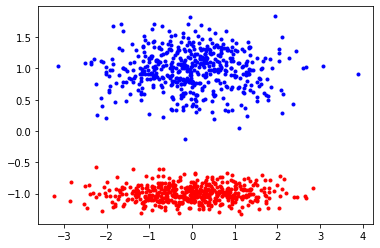

Weights for linear separability model using Perceptron Algorithm:
[[-11.1       ]
 [  3.32746949]
 [-87.3277609 ]]

Columns are actual value, Rows are predicted value:
Training Data Confusion Matrix:
       1.0  -1.0
 1.0   450     0
-1.0     0   450

Testing Data Confusion Matrix:
      -1.0   1.0
-1.0    50     0
 1.0     0    50

   Train Accuracy  Train Precision  Train Recall  Test Accuracy  Test Precision  Test Recall
0             1.0              1.0           1.0            1.0             1.0          1.0


In [8]:
df1, target1 = generateSeperableData(1000)
runPerceptronAlgo(df1, target1, 0.1)

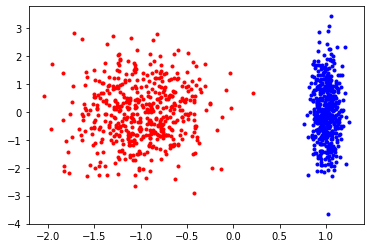

Weights for linear separability model using Perceptron Algorithm:
[[ 14.6       ]
 [-86.33903187]
 [  6.1375125 ]]

Columns are actual value, Rows are predicted value:
Training Data Confusion Matrix:
      -1.0   1.0
-1.0   447     0
 1.0     0   453

Testing Data Confusion Matrix:
       1.0  -1.0
 1.0    47     0
-1.0     0    53

   Train Accuracy  Train Precision  Train Recall  Test Accuracy  Test Precision  Test Recall
0             1.0              1.0           1.0            1.0             1.0          1.0


In [9]:
df2, target2 = generateSeperableData(1000)
runPerceptronAlgo(df2, target2, 0.1)

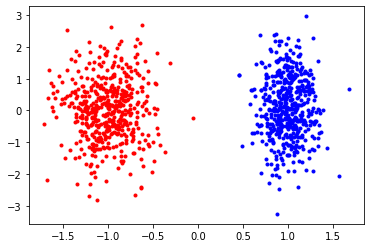

Weights for linear separability model using Perceptron Algorithm:
[[  1.        ]
 [-89.67968018]
 [ -4.2461153 ]]

Columns are actual value, Rows are predicted value:
Training Data Confusion Matrix:
      -1.0   1.0
-1.0   445     0
 1.0     0   455

Testing Data Confusion Matrix:
       1.0  -1.0
 1.0    45     0
-1.0     0    55

   Train Accuracy  Train Precision  Train Recall  Test Accuracy  Test Precision  Test Recall
0             1.0              1.0           1.0            1.0             1.0          1.0


In [10]:
df3, target3 = generateSeperableData(1000)
runPerceptronAlgo(df3, target3, 0.1)

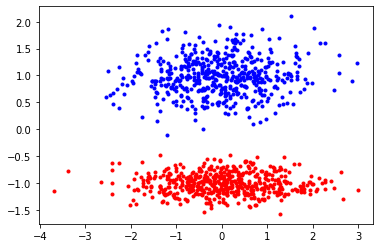

Weights for linear separability model using Perceptron Algorithm:
[[ -2.8       ]
 [  5.11006123]
 [-90.03760559]]

Columns are actual value, Rows are predicted value:
Training Data Confusion Matrix:
      -1.0   1.0
-1.0   455     0
 1.0     0   445

Testing Data Confusion Matrix:
      -1.0   1.0
-1.0    45     0
 1.0     0    55

   Train Accuracy  Train Precision  Train Recall  Test Accuracy  Test Precision  Test Recall
0             1.0              1.0           1.0            1.0             1.0          1.0


In [11]:
df4, target4 = generateSeperableData(1000)
runPerceptronAlgo(df4, target4, 0.1)

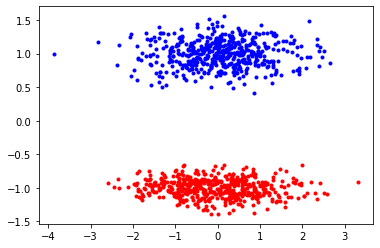

Weights for linear separability model using Perceptron Algorithm:
[[ -0.4       ]
 [ -5.73379191]
 [-90.07385526]]

Columns are actual value, Rows are predicted value:
Training Data Confusion Matrix:
       1.0  -1.0
 1.0   448     0
-1.0     0   452

Testing Data Confusion Matrix:
      -1.0   1.0
-1.0    48     0
 1.0     0    52

   Train Accuracy  Train Precision  Train Recall  Test Accuracy  Test Precision  Test Recall
0             1.0              1.0           1.0            1.0             1.0          1.0


In [12]:
df5, target5 = generateSeperableData(1000)
runPerceptronAlgo(df5, target5, 0.1)

### Using Perceptron for Multiclass Classificaiton:
If the problem becomes a multi-class problem, the solution is quite simple. For each class, a copy of the data should be labeled via 'belongs to class' or 'doesn't belong to class', basically turning them into binary data sets. Then each of these datasets can be passed through the perceptron algorithm to generate weights to allow seperability. This means that as long as all 3 sets of weights are checked, we can be certain that any new datapoint will be classified into the correct class.